<a href="https://colab.research.google.com/github/conglapgit45/Vision_Transformer/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train from Scratch

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [2]:
# download
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
!unzip ./flower_photos.zip

# load data
data_patch = "./flower_photos"
dataset = ImageFolder(root=data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

# split
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=51578421-3bfa-4b05-8790-bb28156b7333
To: /content/flower_photos.zip
100% 230M/230M [00:03<00:00, 62.2MB/s]
Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/104377705

In [3]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# apply
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

In [4]:
# DataLoader

BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size = BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE
)

In [5]:
# Modeling

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            batch_first = True
        )

        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )

        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2


class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x)   # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

        x = x + self.positional_embedding.to(self.device)
        return x


class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(image_size = image_size, embed_dim=embed_dim, patch_size=patch_size, device=device)
        self.transformer_layer = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)
        # self.pooling = nn.AvgPool1d(kernel_size = max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [6]:
# Training

import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1)==labels ).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time . time () - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches"
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


# evaluate
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1)==labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


# train
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

            times.append(time.time() - epoch_start_time)
            # Print loss, acc end epoch
            print("-" * 59)
            print(
                "| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f}"
                "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}". format(
                    epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
                )
            )
            print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy ': train_accs,
        'train_loss ': train_losses,
        'valid_accuracy ': eval_accs,
        'valid_loss ': eval_losses,
        'time ': times
    }
    return model, metrics


image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

model = VisionTransformerCls(image_size=image_size, embed_dim=embed_dim, num_heads=num_heads , ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

model, metrics = train(model, model_name, save_model, optimizer, criterion, train_loader, val_loader,num_epochs, device)

Device:  cuda
-----------------------------------------------------------
| End of epoch   1 | Time : 17.13s | Train Accuracy    0.316 | Train Loss    1.610| Valid Accuracy    0.395 | Valid Loss    1.429
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time : 15.53s | Train Accuracy    0.382 | Train Loss    1.376| Valid Accuracy    0.362 | Valid Loss    1.391
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time : 15.81s | Train Accuracy    0.431 | Train Loss    1.300| Valid Accuracy    0.411 | Valid Loss    1.379
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time : 16.14s | Train Accuracy    0.439 | Train Loss    1.255| Valid Accuracy    0.447 | Valid Loss    1.290
----------------------------------------------

<ipython-input-6-c237efe31b9b>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


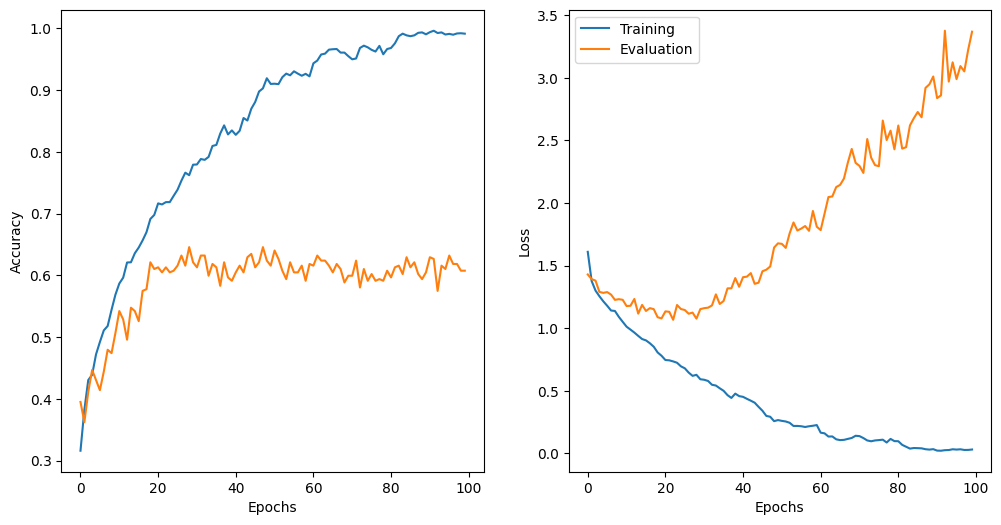

In [11]:
# Visualize result

import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, metrics['train_accuracy '], metrics['valid_accuracy '], metrics['train_loss '], metrics['valid_loss '])

# Fine Tuning

In [8]:
# Modeling

from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id, label in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels = num_classes,
    id2label = id2label,
    label2id = label2id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device:  cuda


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [12]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [13]:
# Metric
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
# Trainer
import torch
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    num_train_epochs = 10,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
    logging_dir = 'logs',
    remove_unused_columns = False,
)

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    tokenizer = feature_extractor,
)


# Training
trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metrics

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-2f84da89542c>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.563466,0.950954
2,No log,0.266098,0.975477
3,No log,0.192740,0.980926
4,No log,0.170484,0.975477
5,No log,0.159270,0.975477
6,0.337400,0.152487,0.970027
7,0.337400,0.150533,0.970027
8,0.337400,0.149945,0.970027
9,0.337400,0.149531,0.972752
10,0.337400,0.149092,0.970027


{'test_loss': 0.1895895004272461,
 'test_accuracy': 0.9727520435967303,
 'test_runtime': 6.0109,
 'test_samples_per_second': 61.056,
 'test_steps_per_second': 1.996}

In [19]:
from google.colab import files
import torch
import torchvision.transforms as transforms
from PIL import Image

# Using the best model
model_path = '/content/vit_flowers/vit_flowers.pt'  # Or the fine-tuned model path
model = VisionTransformerCls(image_size=224, embed_dim=512, num_heads=4, ff_dim=128, dropout=0.1, num_classes=num_classes, device=device)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()


# Pineline of transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Upload image from browser
uploaded = files.upload()
image_name = list(uploaded.keys())[0]
image_path = image_name

try:
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = classes[predicted.item()]
    print(f"Predicted class: {predicted_class}")

except Exception as e:
    print(f"An error occurred: {e}")

<ipython-input-19-c9a958a9b0c3>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Saving images.jpg to images (3).jpg
Predicted class: dandelion
